C:\Users\guiga\AppData\Local\Temp\ipykernel_19560\42727145.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2024-08-01', end='2025-08-01')
[*********************100%***********************]  1 of 1 completed


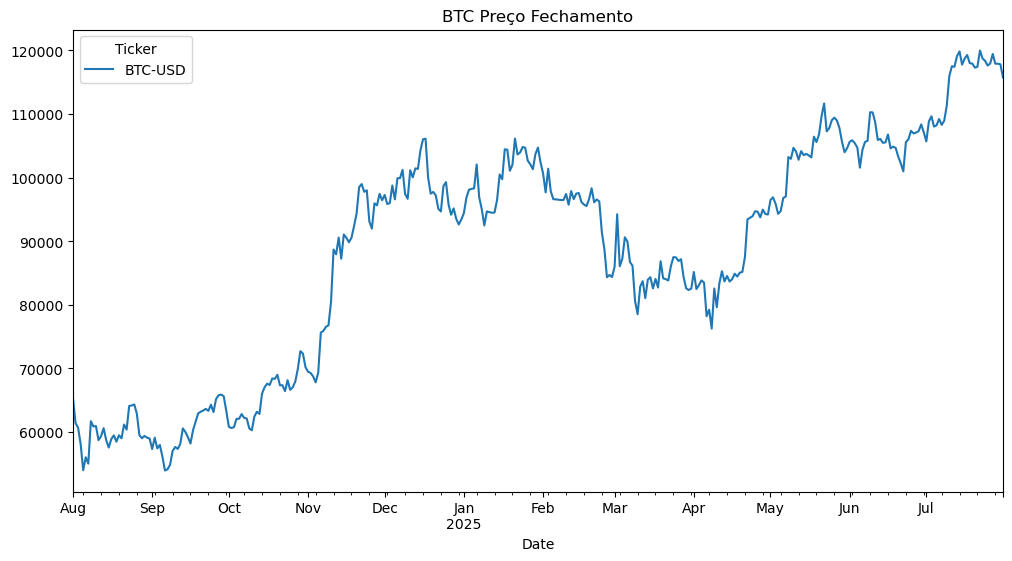

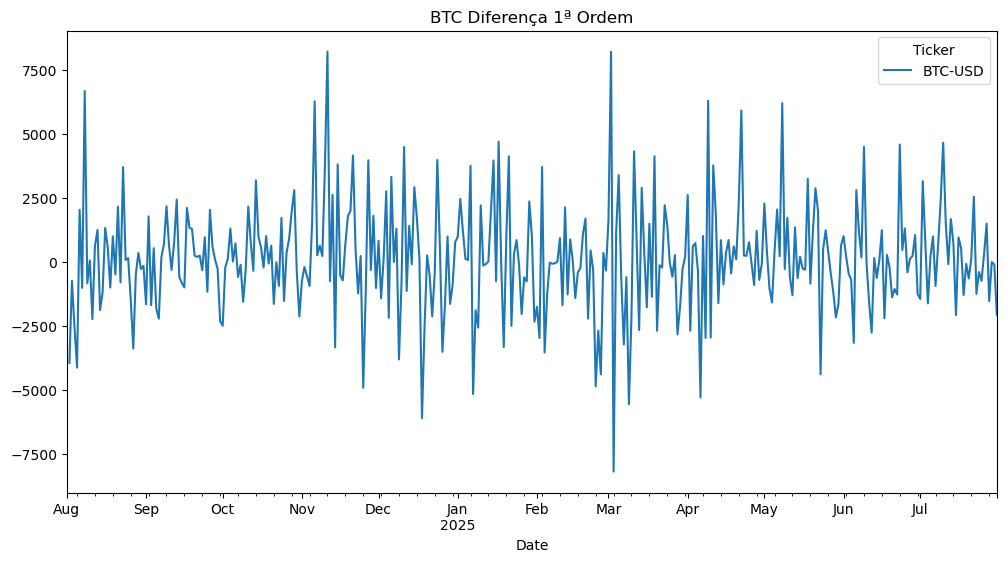

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

# carregar 1 ano para ficar leve
btc = yf.download('BTC-USD', start='2024-08-01', end='2025-08-01')

# preço original
btc['Close'].plot(figsize=(12,6), title='BTC Preço Fechamento')
plt.show()

# primeira diferença (I=1)
btc['Close'].diff().plot(figsize=(12,6), title='BTC Diferença 1ª Ordem')
plt.show()


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ajuste o caminho do seu CSV
csv_path = 'data/btc_limpo.csv'  # troque se necessário

# tenta carregar com 'Date' como coluna
try:
    btc = pd.read_csv(csv_path, parse_dates=['Date'])
    if 'Date' in btc.columns:
        btc = btc.set_index('Date')
except Exception:
    # fallback: primeira coluna é o índice de datas
    btc = pd.read_csv(csv_path, index_col=0)
    btc.index = pd.to_datetime(btc.index)

# manter só o que interessa hoje
btc = btc.sort_index()
btc['Close'] = pd.to_numeric(btc['Close'], errors='coerce')
btc = btc[['Close']].dropna()

print(btc.index.min(), '→', btc.index.max(), '| linhas:', len(btc))
btc.tail()


2020-06-01 00:00:00 → 2025-05-31 00:00:00 | linhas: 1826


,Close
Date,
2025-05-27,108994.640625
2025-05-28,107802.328125
2025-05-29,105641.757812
2025-05-30,103998.570312
2025-05-31,104638.093750


In [5]:
test_days = 30
if len(btc) <= test_days + 30:
    # fallback: 20% para teste se a série for curta
    split_idx = int(len(btc) * 0.8)
    train = btc.iloc[:split_idx].copy()
    test  = btc.iloc[split_idx:].copy()
else:
    train = btc.iloc[:-test_days].copy()
    test  = btc.iloc[-test_days:].copy()

y_all = btc['Close']
y_train = train['Close']
y_test  = test['Close']

print('treino:', y_train.index.min(), '→', y_train.index.max(), '| n =', len(y_train))
print('teste :', y_test.index.min(),  '→', y_test.index.max(),  '| n =', len(y_test))


treino: 2020-06-01 00:00:00 → 2025-05-01 00:00:00 | n = 1796
teste : 2025-05-02 00:00:00 → 2025-05-31 00:00:00 | n = 30


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# previsão ingênua: valor de ontem
y_hat_naive = y_all.shift(1).loc[y_test.index]

# alinhar e remover possíveis NaNs
common_idx = y_test.index.intersection(y_hat_naive.dropna().index)
y_true = y_test.loc[common_idx]
y_pred_naive = y_hat_naive.loc[common_idx]

def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100

mae_naive  = mean_absolute_error(y_true, y_pred_naive)
rmse_naive = mean_squared_error(y_true, y_pred_naive, squared=False)
mape_naive = mape(y_true, y_pred_naive)

print('NAIVE → MAE:', mae_naive, '| RMSE:', rmse_naive, '| MAPE (%):', mape_naive)


TypeError: got an unexpected keyword argument 'squared'

In [7]:
import sklearn
print(sklearn.__version__)



1.6.1


In [9]:
import sklearn
print(sklearn.__version__)


1.6.1


In [10]:
import sklearn
import inspect
from sklearn.metrics import mean_squared_error

print("Versão do scikit-learn:", sklearn.__version__)
print("Função carregada de:", inspect.getfile(mean_squared_error))
help(mean_squared_error)


Versão do scikit-learn: 1.6.1
Função carregada de: C:\Users\guiga\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py
Help on function mean_squared_error in module sklearn.metrics._regression:

mean_squared_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average'
)
    Mean squared error regression loss.

    Read more in the :ref:`User Guide <mean_squared_error>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    multioutput : {'raw_values', 'uniform_average'} or array-like of shape             (n_outputs,), default='uniform_average'
        Defines aggregating of multiple output values.
        Array-like value defines weights used to ave

NAIVE → MAE: 1378.1346354166667 | RMSE: 1913.366379213541 | MAPE (%): 1.3190740620530594


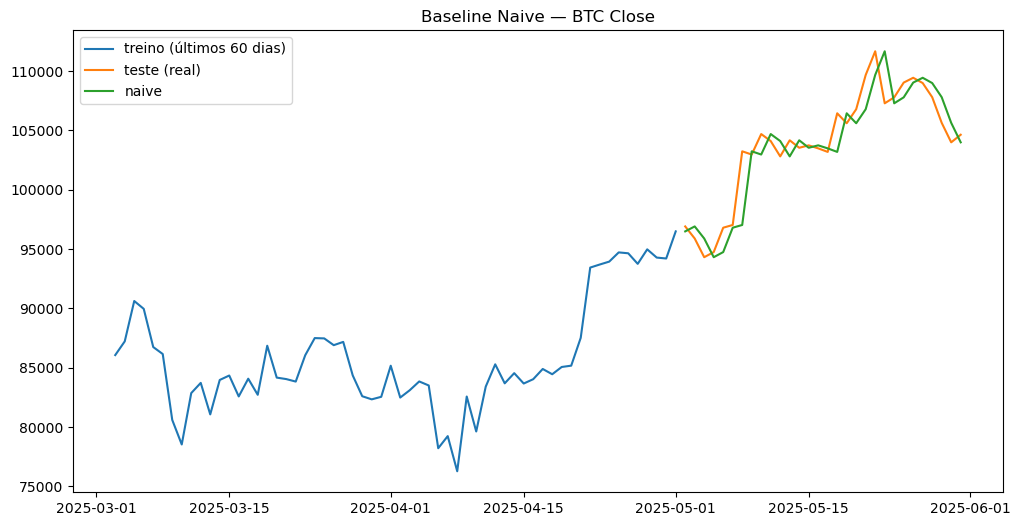

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100

# MAE
mae_naive = mean_absolute_error(y_true, y_pred_naive)

# RMSE (manual, raiz quadrada do MSE)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred_naive))

# MAPE
mape_naive = mape(y_true, y_pred_naive)

print('NAIVE → MAE:', mae_naive, '| RMSE:', rmse_naive, '| MAPE (%):', mape_naive)

plt.figure(figsize=(12,6))
plt.plot(y_train[-60:], label='treino (últimos 60 dias)')
plt.plot(y_true, label='teste (real)')
plt.plot(y_pred_naive, label='naive')
plt.title('Baseline Naive — BTC Close')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

lag = 7
y_hat_snaive7 = y_all.shift(lag).loc[y_test.index]
idx2 = y_test.index.intersection(y_hat_snaive7.dropna().index)
y_true2 = y_test.loc[idx2]
y_pred_snaive7 = y_hat_snaive7.loc[idx2]

mae_s7  = mean_absolute_error(y_true2, y_pred_snaive7)
rmse_s7 = mean_squared_error(y_true2, y_pred_snaive7, squared=False)
mape_s7 = mape(y_true2, y_pred_snaive7)
print('S-NAIVE(7) → MAE:', mae_s7, '| RMSE:', rmse_s7, '| MAPE (%):', mape_s7)


TypeError: got an unexpected keyword argument 'squared'

In [17]:
import inspect
from sklearn.metrics import mean_squared_error

print(mean_squared_error)              # mostra de onde vem
print(inspect.getfile(mean_squared_error))  # mostra o caminho do arquivo real


<function mean_squared_error at 0x000001E256232020>
C:\Users\guiga\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py


In [1]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error.__module__)


sklearn.metrics._regression


C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 7713.674715918871
RMSE: 8720.146151391891
MAPE (%): 7.266038238598085


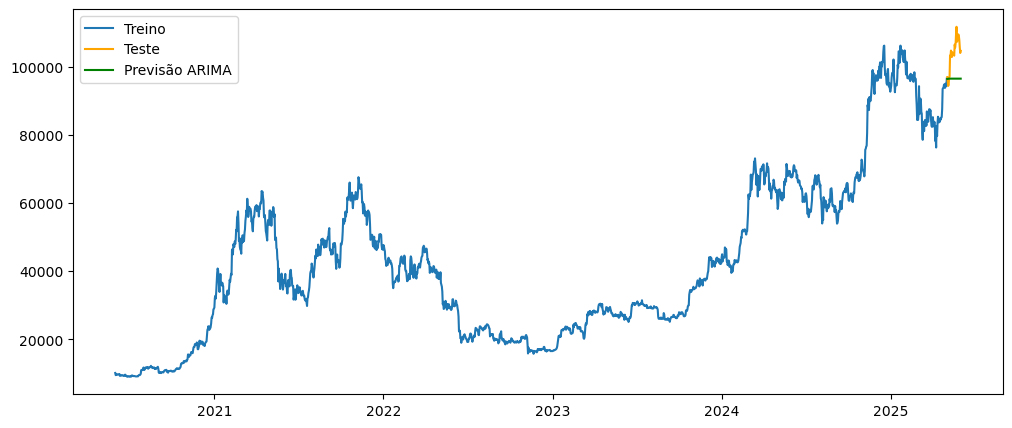

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
# Exemplo genérico — troque pelo seu dataset de preços do BTC
data = pd.read_csv("data/btc_limpo.csv", parse_dates=["Date"], index_col="Date")
y = data["Close"]

train = y.iloc[:-30]   # tudo menos últimos 30 dias
test  = y.iloc[-30:]   # últimos 30 dias

model = ARIMA(train, order=(5,1,0))  # ARIMA(p=5, d=1, q=0) como exemplo
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
rmse_val = rmse(test, forecast)
mape_val = mape(test, forecast)

print("MAE:", mae)
print("RMSE:", rmse_val)
print("MAPE (%):", mape_val)

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Treino")
plt.plot(test.index, test, label="Teste", color="orange")
plt.plot(test.index, forecast, label="Previsão ARIMA", color="green")
plt.legend()
plt.show()


In [3]:
print(model_fit.model_orders)          # mostra p,d,q
print(model_fit.model.trend)           # 'n', 'c', 't'...
print(model_fit.summary())             # coeficientes e significância



{'trend': 0, 'exog': 0, 'ar': 5, 'ma': 0, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 5, 'reduced_ma': 0, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}
n
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1796
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15637.292
Date:                Sat, 30 Aug 2025   AIC                          31286.584
Time:                        17:26:11   BIC                          31319.540
Sample:                    06-01-2020   HQIC                         31298.751
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0628      0.016  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supondo que você já tenha df['Date'] e df['Close']
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Preço original
df['Close'].plot(figsize=(12,5), title="Preço do Bitcoin")
plt.show()

# Retornos diários (%)
df['Return'] = df['Close'].pct_change()
df['Return'].plot(figsize=(12,5), title="Retorno Diário (%)")
plt.show()

# Correlação temporal (ACF/PACF)
plot_acf(df['Return'].dropna(), lags=30)
plt.show()
plot_pacf(df['Return'].dropna(), lags=30)
plt.show()
